In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import dl_utils

In [24]:
import chardet    
rawdata = open(path, 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']
print(charenc)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OneDrive\\Desktop\\2Learning-Pytorch-Geometric\\Learning_Pytorch\\Data\\House-prices\\test.cvs'

In [36]:
import os

path ='Data\House-prices\sample_submission.csv'
path = os.path.join(os.getcwd( ), path)
sampledata = pd.read_csv(path)
sampledata.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [40]:
train_path ='Data\\House-prices\\train.csv'
test_path  = 'Data\\House-prices\\test.csv'

train_data = pd.read_csv(os.path.join(os.getcwd(), train_path))
test_data = pd.read_csv(os.path.join( os.getcwd(), test_path))

print(train_data.shape)
print(test_data.shape)

print(type(train_data))

(1460, 81)
(1459, 80)
<class 'pandas.core.frame.DataFrame'>


训练数据集包括1460个样本、80个特征和1个标签。\
测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [41]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [42]:
test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,2010,WD,Normal
1,1462,20,RL,81.0,2010,WD,Normal
2,1463,60,RL,74.0,2010,WD,Normal
3,1464,60,RL,78.0,2010,WD,Normal


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [47]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort = False)

# cat test and train  witout id  and saleprice

In [50]:
all_features.shape

(2919, 79)

In [49]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning\_RL和MSZoning\_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning\_RL=1且MSZoning\_RM=0。

In [55]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape # (2919, 354)
print(type(all_features))
print(type(all_features.values))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


可以看到这一步转换将特征数从79增加到了354。
最后，通过`values`属性得到NumPy格式的数据，并转成`NDArray`方便后面的训练。

In [61]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values,  dtype = torch.float)
test_features = torch.tensor(all_features[n_train: ].values,  dtype = torch.float)

train_labels = torch.tensor(train_data.iloc[:, -1].values, dtype = torch.float).view(-1,1)

print(train_labels.size(), train_labels.dtype)

torch.Size([1460, 1]) torch.float32


In [59]:
x = np.array([[2,4,52,5],[3,4,1,2]])
x[:,-1]

array([5, 2])

## 训练模型

我们使用一个基本的线性回归模型和平方损失函数来训练模型。


下面定义比赛用来评价模型的对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.$$

对数均方根误差的实现如下。

In [80]:
y = [1,3,4,5]
y_hat = [1,1,1,3]

def get_net(features_num):
    net = nn.Linear(features_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean = 0, std = 0.01)
    return net

def log_RMSE(y_labels, y_hat):
    with torch.no_grad():
        preds = torch.max(y_hat, torch.tensor(1.0))
    #取对数，小于1 的输出 等于 1 ， 使得对数数值更稳定
        return torch.sqrt(  ((torch.log(y_labels) - torch.log(y_hat))**2).mean() ).item()

In [81]:
y = [1,1,1,3.8]
y_hat = [1,1,1,3.0]
y = torch.tensor(y)
y_hat = torch.tensor(y_hat)

x = (torch.log(y) - torch.log(y_hat))**2
print(log_RMSE(y, y_hat))

0.11819440126419067


面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”一章里详细介绍它。

In [100]:
def train(net, train_features, train_labels, test_features, test_labels, learning_rete, weight_decay, batch_size):
    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rete, weight_decay=weight_decay) 
    
    for X, y in train_dataloader:
        y_hat = net(X)
        
        l = loss(y, y_hat)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
    if test_labels is not None: 
         return log_RMSE(train_labels, net(train_features)), log_RMSE(test_labels, net(test_labels))
    else:    
        return log_RMSE(train_labels, net(train_features)), None
        
    
epochs = 100
loss = torch.nn.MSELoss()

net = get_net(354)

train_loss, test_loss = [], []
for epoch in range(epochs):
    
    
    
    train_l, test_l  = train(net, train_features, train_labels, test_features, None, learning_rete = 5, weight_decay = 0.1, batch_size = 64)
    
    train_loss.append(train_l)
    test_loss.append(test_l)
    
    
    

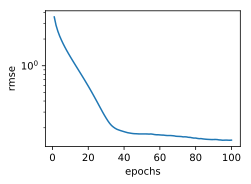

In [101]:
from imp import reload
reload(dl_utils)
dl_utils.semilogy(range(1, epochs+1), train_loss, 'epochs', 'rmse')



## $K$折交叉验证

我们在3.11节（模型选择、欠拟合和过拟合）中介绍了$K$折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第`i`折交叉验证时所需要的训练和验证数据。

In [102]:
#将训练集分为 训练子集 和 验证集
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [103]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [109]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            print('show plt')
            dl_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

show plt
fold 0, train rmse 0.239802, valid rmse 0.220410
fold 1, train rmse 0.229657, valid rmse 0.271741
fold 2, train rmse 0.231750, valid rmse 0.238593
fold 3, train rmse 0.238245, valid rmse 0.218998
fold 4, train rmse 0.229807, valid rmse 0.258011
5-fold validation: avg train rmse 0.233852, avg valid rmse 0.241551


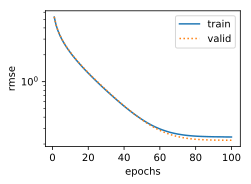

In [110]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

## 模型选择

我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。

```python
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))
```

有时候你会发现一组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

## 预测并在Kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

train rmse 0.230064


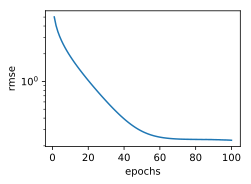

In [112]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    dl_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
    # 对于只有一个元素的tensor 用item() 对于 多维的tensor 用 detach()
    
    #准备输出结果
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    
    submission.to_csv('./submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)